# Devoir Python

Vous devez rendre votre devoir sur GitHub.
Vous avez le droit a tout vos documents et a internet

1. votre depot doit etre privé
2. vous devez inviter comme colaborateur votre chargé de TD/TP
3. Seul le dernier commit avant la fin de la séance sera corrigé.


Ex 1: Integrale de Romberg

Ecrire une fonction integ_romberg(f, a, b, epsilon=1e-6) permettant de calculer l’intégrale numérique de la fonction f entre les bornes a et b avec une précision epsilon selon la méthode de Romberg (https://fr.wikipedia.org/wiki/M%C3%A9thode_de_Romberg).

Il s’agit d’une méthode qui permet d’améliorer les méthodes usuelles de calcul numérique des intégrales, comme la méthode des Trapèzes.
On montre qu’en combinant judicieusement les valeurs obtenues par la méthode des Trapèzes pour différentes subdivisons de l’intervalle d’intégration, on augmente l’ordre de convergence (sa vitesse de convergence). 


In [22]:
import numpy as np

def fonction(x):         # fonction qui nous servira pour les tests
   f = 2 * x * x + 3*x + 4
   return f

def trapeze(f,a,b,N):    # methode des trapezes pour calculer l'integral, N = nombre de rectangles
    h   = (b-a)/N
    xi  = np.linspace(a,b,N+1)
    fi  = f(xi)
    s   = 0.0           # initialisation de la somme
    for i in range(1,N):       # Ici on créé les différents trapèzes "sous la courbe"
        s = s + fi[i]
    s = (h/2)*(fi[0] + fi[N]) + h*s     # on calcule la surface totale de ces trapèzes
    return s

def integ_romberg(f,a,b,epsilon,tailleMax):      # methode de Romberg
    Q = np.zeros((tailleMax,tailleMax),float)        # on créé le tableau avec la dimension nmax (pour limiter sa taille)
    c = 0.0                                  # condition qui nous permettra de voir si l'on converge avec epsilon
    for i in range(0,tailleMax):
        N = 2**i
        Q[i,0] = trapeze(f,a,b,N)            # on applique la methode des trapezes sur a et b pour N => nombre de trapèzes
        for k in range(0,i):
            n = k + 2
            Q[i,k+1] = 1.0/(4**(n-1)-1)*(4**(n-1)*Q[i,k] - Q[i-1,k])
        if (i > 0):
            if (abs(Q[i,k+1] - Q[i,k]) < epsilon):     # on verifie l'écart entre les deux valeurs et on arrête si c'est
               c = 1                                 # trop proche de epsilon
               break
    return Q[i,k+1]

a  = -2.0
b = 2.0
print(integ_romberg(fonction,a,b,1.0e-6,100))

26.66666666666666


Ex 2: Équation d’état de l’eau à partir de la dynamique moléculaire

Afin de modéliser les planètes de type Jupiter, Saturne, ou même des exo-planètes très massives (dites « super-Jupiters »), la connaissance de l’équation d’état des composants est nécessaire. Ces équations d’état doivent être valables jusqu’à plusieurs centaines de méga-bar ; autrement dit, celles-ci ne sont en aucun cas accessibles expérimentalement. On peut cependant obtenir une équation d’état numériquement à partir d’une dynamique moléculaire.

Le principe est le suivant : on place dans une boite un certain nombre de particules régies par les équations microscopiques (Newton par exemple, ou même par des équations prenant en considération la mécanique quantique) puis on laisse celles-ci évoluer dans la boite ; on calcule à chaque pas de temps l’énergie interne à partir des intéractions électrostatiques et la pression à partir du tenseur des contraintes. On obtient en sortie l’évolution du système pour une densité fixée (par le choix de taille de la boite) et une température fixée (par un algorithme de thermostat que nous ne détaillerons pas ici).

On se propose d’analyser quelques fichiers de sortie de tels calculs pour l’équation d’état de l’eau à très haute pression. Les fichiers de sortie sont disponibles ici; leur nom indique les conditions thermodynamiques correspondant au fichier, p.ex. 6000K_30gcc.out pour T=6000
K et ρ=30 gcc. Le but est, pour chaque condition température-densité, d’extraire l’évolution de l’énergie et de la pression au cours du temps, puis d’en extraire la valeur moyenne ainsi que les fluctuations. Il arrive souvent que l’état initial choisi pour le système ne corresponde pas à son état d’équilibre, et qu’il faille donc « jeter » les quelques pas de temps en début de simulation qui correspondent à cette relaxation du système. Pour savoir combien de temps prend cette relaxation, il sera utile de tracer l’évolution au cours du temps de la pression et l’énergie pour quelques simulations. Une fois l’équation d’état P(ρ,T) et E(ρ,T) extraite, on pourra tracer le réseau d’isothermes.

In [44]:
#enlever les 20 premieres valeurs

import numpy as N
import matplotlib.pyplot as P

"""
Construction d'un système d'extraction et d'analyse de fichiers de sortie de
dynamique moléculaire afin d'extraire les grandeurs thermodynamiques.
On affichera les ensuite isothermes.
"""

tolerance = 1e-8  # tolerances pour egalités rééls


##############################
##### A Simulation class #####
##############################

class Simulation:
    """
    La classe Simulation représente une simulation de dynamique
    moléculaire, donc un point de l'équation d'état. Son constructeur
    doit impérativement être appelé avec le chemin du fichier output
    correspondant. Elle possède des méthodes pour extraire les grandeurs
    thermodynamiques et afficher la run, en pouvant enlever certains pas
    de temps en début de simulation.
    """

    def __init__(self, temp, dens, path):
        """
        Le constructeur doit impérativement être appelé avec le chemin du
        fichier décrivant la simulation, ainsi que ses conditions
        thermodynamiques.

        Args :
                temp,dens(float): La température et la densité de la simulation
                path(string): Le chemin vers le fichier décrivant la simulation

        Raises :
                TypeError si temp ou dens ne sont pas des réels
                IOError si le fichier n'existe pas
        """
        self.temp = float(temp)
        self.dens = float(dens)
        tmp = N.loadtxt(path, skiprows=1).T
        self.pot = tmp[0]
        self.kin = tmp[1]
        self.tot = self.pot + self.kin
        self.press = tmp[2]

    def __str__(self):
        """
        Surcharge de l'opérateur str.
        """
        return "Simulation at {:.0f} g/cc and {:.0f} K ; {:d} timesteps". \
            format(self.dens, self.temp, len(self.pot))

    def thermo(self, skipSteps=0):
        """
        Calcule l'énergie et la pression moyenne au cours de la simulation.
        Renvoie un dictionnaire.

        Args:
                skipSteps(int): Nb de pas à enlever en début de simulation.

        Returns:
                {'T':temperature, 'rho':density,
                 'E':energy, 'P':pressure,
                 'dE':dEnergy, 'dP':dPressure}
        """
        return {'T': self.temp,
                'rho': self.dens,
                'E': self.tot[skipSteps:].mean(),
                'P': self.press[skipSteps:].mean(),
                'dE': self.tot[skipSteps:].std(),
                'dP': self.press[skipSteps:].std()}

    def plot(self, skipSteps=0):
        """
        Affiche l'évolution de la Pression et l'énergie interne au cours de
        la simulation.

        Args:
                skipSteps(int): Pas de temps à enelevr en début de simulation.

        Raises:
                TypeError si skipSteps n'est pas un entier.
        """
        fig, (axen, axpress) = P.subplots(2, sharex=True)
        axen.plot(list(range(skipSteps, len(self.tot))), self.tot[skipSteps:],
                  'rd--')
        axen.set_title("Internal energy (Ha)")
        axpress.plot(list(range(skipSteps, len(self.press))), self.press[skipSteps:],
                     'rd--')
        axpress.set_title("Pressure (GPa)")
        axpress.set_xlabel("Timesteps")

        P.show()

"""
On définit un certain nombre de pas de temps à sauter, puis on
charge chaque simulation et extrait les informaions thermodynamiques
associées. On affiche enfin les isothermes normalisées (E/NkT et P/nkT).
"""

    ### Les variables ###
a0 = 0.52918      # Bohr radius in angstrom
amu = 1.6605      # atomic mass unit in e-24 g
k_B = 3.16681e-6  # Boltzmann's constant in Ha/K 
nk_GPa = a0 ** 3 * k_B * 2.942e4 / 6 / amu   # facteur de normalisation pour P/nkT
nsteps = 200  # define skipped timesteps (should be done foreach simulation...)
temps = [6000, 20000, 50000]    # define temperatures
colors = {6000: 'r', 20000: 'b', 50000: 'k'}
denss = [7, 15, 25, 30]  # define densities
keys = ['T', 'rho', 'E', 'dE', 'P', 'dP']
eos = dict.fromkeys(keys, N.zeros(0))   # {key:[]}



### On extrait les données des fichiers sources ###
for t, rho in [(t, rho) for t in temps for rho in denss]:
    filenm = "outputs/{}K_{:0>2d}gcc.out".format(t, rho)
    s = Simulation(t, rho, filenm)
    for key in keys:
        eos[key] = N.append(eos[key], s.thermo(nsteps)[key])

### On génére le graphique correspondant ###
fig, (axen, axpress) = P.subplots(2, sharex=True)
fig.suptitle("High-pressure equation of state for water", size='x-large')
axen.set_title("Energy")
axen.set_ylabel("U / NkT")
axpress.set_title("Pressure")
axpress.set_ylabel("P / nkT")
axpress.set_xlabel("rho (g/cc)")
for t in temps:
    sel = eos['T'] == t
    axen.errorbar(x=eos['rho'][sel], y=eos['E'][sel] / k_B / t,
                 yerr=eos['dE'][sel] / k_B / t, fmt=colors[t] + '-')
    axpress.errorbar(x=eos['rho'][sel],
                    y=eos['P'][sel] / eos['rho'][sel] / nk_GPa / t,
                    yerr=eos['dP'][sel] / eos['rho'][sel] / nk_GPa / t,
                    fmt=colors[t] + '-',
                    label="{} K".format(t))
    axpress.legend(loc='best')
    P.show()

OSError: outputs/6000K_07gcc.out not found.

Ex 3: Le problème du voyageur de commerce

Le problème du voyageur de commerce est un problème d’optimisation consistant à déterminer le plus court chemin reliant un ensemble de destinations. Il n’existe pas d’algorithme donnant la solution optimale en un temps raisonnable (problème NP-complet), mais l’on peut chercher à déterminer des solutions approchées. On va se placer ici dans le cas d’un livreur devant desservir une seule fois chacune desndestinations d’une ville américaine où les rues sont agencées en réseau carré. 

On utilise la « distance deManhattan »  entre deux points 𝐴(𝑥𝐴,𝑦𝐴) et 𝐵(𝑥𝐵,𝑦𝐵) : 𝑑(𝐴,𝐵) =|𝑥𝐵−𝑥𝐴|+|𝑦𝐵−𝑦𝐴|.

En outre, on se place dans le cas où les coordonnées des destinations sont entières, comprises entre 0 (inclus) et TAILLE = 50 (exclus). Deux destinations peuvent éventuellement avoir les mêmes coordonnées. Les instructions suivantes doivent permettre de définir les classes nécessaires (Ville et Trajet) et de développer un algorithme approché (heuristiques) : l’algorithme du plus proche voisin. 

Seules la librairie standard et la librairie numpy sont utilisables si nécessaire. Implementer les classes et methodes suivante:


Classe Ville:
* __init__(): initialisation d’une ville sans destination.
* aleatoire(n): création de n destinations aléatoires.
* nb_trajet(): retourne le nombre total (entier) de trajets :(𝑛−1)!/2(utilisermath.factorial()).
* distance(i, j): retourne la distance (Manhattan) entre les deux destinations de numéro i et j


Classe Trajet:
* __init__(ville, etapes=None): initialisation sur une ville. Si la liste etapes n’est pas spécifiée, le trajet par défaut est celui suivant les destinations de ville.
* longueur(): retourne la longueur totale du trajetbouclé(i.e. revenant à son point de départ).


Plus proche voisin:
* Ville.plus_proche(i, exclus=[]): retourne la destination la plus proche de la destinationi(au sens de Ville.distance()), hors les destinations de la liste exclus
* Ville.trajet_voisins(depart=0): retourne un Trajet déterminé selon l’heuristique des plus proches voisins (i.e. l’étape suivante est la destination la plus proche hors les destinations déjà visitées) en partant de l’étape initiale depart

Optimisation:
* Proposer un algorithme qui propose une meilleur alternative au "plus proche voisin".

Interface:
* Ville.figure(trajet=None): Afficher le plande la ville et le trajet obtenue (utiliser matplotlib.step()pour des trajets de type « Manhattan »)

10 trajet(s), Longeur=304: [0 1 2 3 4 5 6 7 8 9] étapes
Trajet plus proche voisin :  10 trajet(s), Longeur=278: [0 5 6 8 3 4 2 1 9 7] étapes
Trajet optimisé :  10 trajet(s), Longeur=262: [0 5 7 8 3 4 2 1 9 6] étapes


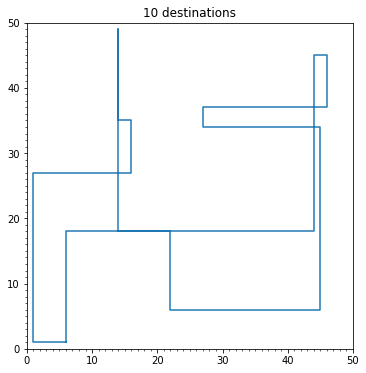

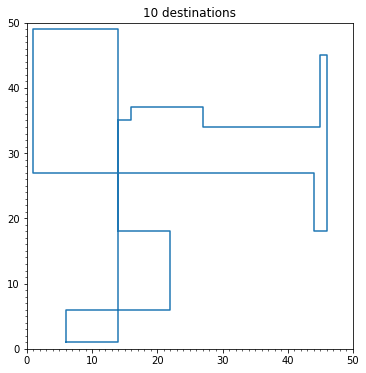

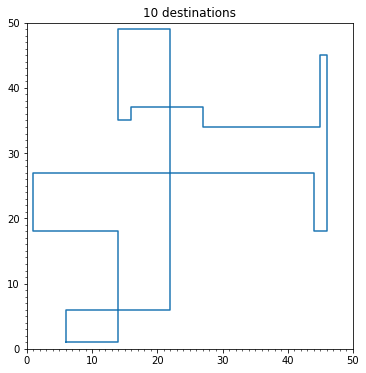

In [46]:
import math
import numpy as N
import matplotlib.pyplot as P

TAILLE = 50

class Ville(object):

   #contient une liste de destinations

    def __init__(self):
        # pas de destinations
        self.destinations = N.array([]).reshape(-1, 2)

    def __str__(self):
        return "La ville contient : {} destinations pour {} trajets".format(
            len(self.destinations), self.nb_trajets())

    def aleatoire(self, n=20):
        #creations des destinations de manière aléatoire
        self.destinations = N.random.randint(TAILLE, size=(n, 2))

    def nb_trajets(self):
        # Retourne le nombre total (entier) de trajets : ( n - 1 ) ! / 2 
        nb_dests = len(self.destinations)
        val_retour = 0
        if ndest > 2:
            val_retour = int(math.factorial(nb_dests - 1) / 2)
        elif ndest > 0:
            val_retour = 1
        return val_retour

    def distance(self, i, j):
        #retourne la distance (Manhattan) entre les deux destinations de numéro i et j
        return N.abs(self.destinations[i] - self.destinations[j]).sum()

    def plus_proche(self, i, exclus=[]):
        # retourne la destination la plus proche en dehors de la liste d'exclus

        voisins = [ j for j in range(len(self.destinations))  
                    if j != i and j not in exclus ]    # on recupères tous les voisins, donc on s'enleve soi même et on
                                                        # en profite pour supprimer les exclus
        distances = [ self.distance(i, j) for j in voisins ]    # on recupères la distance avec chaque voisins

        return voisins[N.argmin(distances)] # on renvoie le voisin avec la valeur minimale pour distance (argmin)


    def trajet_voisins(self, depart=0):
        #retourne un trajet à partir des voisins les plus proches

        ndest = len(self.destinations)
        trajet = None
        if depart is None:     # on test tous les departs possibles
            trajets = [ self.trajet_voisins(depart=i) for i in range(ndest) ]
            longueurs = [ t.longueur() for t in trajets ]

            trajet = trajets[N.argmin(longueurs)]
        else:                  # dans le cas d'un départ imposé
            etapes = [depart]
            while len(etapes) < ndest:
                i = etapes[-1]
                j = self.plus_proche(i, exclus=etapes[:-1])
                etapes.append(j)    # on ajoute l'etape trouvee

            trajet = Trajet(self, etapes)     # on cree le trajet correspondant
        return trajet

    
    def optimisation_trajet(self, trajet):
        # on renvoie le trajet le plus courts des trajets voisins au trajet
        ndest = len(self.destinations) # on recupere le nombre de destinations
        trajets = [ trajet.interversion(i, j)   # on intervertis les destinations du tableau
                    for i in range(ndest) for j in range(i+1, ndest) ] # pour obtenir tous les cas possibles
        longueurs = [ t.longueur() for t in trajets ]  # on calcule la longueur de chaque trajet
        opt = trajets[N.argmin(longueurs)]   # on renvoie le trajet avec le moins de longueur
        if opt.longueur() > trajet.longueur(): # si le trajet trouvé est moins bien que celui de base alors on le renvoie
            opt = trajet
            
        return opt
    
    def figure(self, trajet=None):
        # figure pour observer un trajet et une ville

        fig = P.figure(figsize=(6,6))
        ax = fig.add_subplot(1,1,1, aspect='equal',
               xlim=(0, TAILLE), ylim=(0, TAILLE),
               title="{} destinations".format(len(self.destinations)))
        minor_loc = P.matplotlib.ticker.MultipleLocator(1)
        ax.xaxis.set_minor_locator(minor_loc)
        ax.yaxis.set_minor_locator(minor_loc)   # on créé la figure vide (parametres de base etc)
        ax.autoscale(False)

        if trajet is None:    # s'il n'y a pas de trajets on se base sur les destinations
            ax.plot(self.destinations[:, 0], self.destinations[:, 1],
                    'ko', zorder=10)
            for i,(x,y) in enumerate(self.destinations): 
                #ax.text(x, y, ' '+str(i))
                ax.annotate(str(i), xy=(x, y), xytext=(x+0.5, y+0.5), zorder=10)
        else:                  # s'il y'a un trajet on se base 
            boucle = N.concatenate((trajet.etapes, [trajet.etapes[0]]))
            ax.step(self.destinations[boucle, 0],
                    self.destinations[boucle, 1],
                    label="L={}".format(trajet.longueur()))

        return ax

    
class Trajet(object):

    #contient une liste ordonnée des destinations (étapes) d'une ville

    def __init__(self, ville, etapes=None):
        # Initialisation sur une ville.  
        # Si pas d'étapes, le trajet par défaut est celui suivant les destinations de ville.
        
        self.ville = ville
        if etapes is None:      # Trajet par défaut (destinations de ville)
            self.etapes = N.arange(len(self.ville.destinations))
        else:
            self.etapes = N.array(etapes)

    def __str__(self):
        return "{} trajet(s), Longeur={}: {} étapes".format(
            len(self.etapes), self.longueur(), self.etapes)

    def longueur(self):
        #retourne la longueur totale bouclé du trajet à partir du nombre d'étapes

        l = sum( self.ville.distance(self.etapes[i], self.etapes[i+1])
                 for i in range(len(self.etapes)-1) )
        l += self.ville.distance(self.etapes[-1], self.etapes[0])   
        # on incremente avec la distance de chaque etape

        return l

    def interversion(self, i, j):
        # retourne un trajet en intervertissant 2 étapes => pour l'optimisation ca permet de rendre
        # le code plus lisible
        etapes = self.etapes.copy()
        etapes[[i, j]] = etapes[[j, i]]
        return Trajet(self.ville, etapes)

ville = Ville()
ville.aleatoire(10)

# Trajet aléatoire
trajet = Trajet(ville)
print(trajet)
ville.figure(trajet)

# Trajet plus proche voisins
trajet_voisins = ville.trajet_voisins(depart=0)
print("Trajet plus proche voisin : ", trajet_voisins)
ville.figure(trajet_voisins)

# Trajet optimisé
trajet_opt = ville.optimisation_trajet(trajet_voisins)
print("Trajet optimisé : ", trajet_opt)
ville.figure(trajet_opt)
